# Loading and outputing data

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
mx.random.seed(1)

In [21]:
#https://stackoverflow.com/questions/30887979/i-want-to-create-a-script-for-unzip-tar-gz-file-via-python
#extract all files from a tar.gz zip file

def extract_file(fname):
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall()
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall()
        tar.close()

In [22]:
#unzips the zip file and creates a folder called cifar-10-batches-py in the directory
tar = extract_file("cifar-10-python.tar.gz")

In [23]:
#reads in each file and returns a dictionary with b'data',b'labels', etc. as keys and arrays of uint8s as data for outputing images
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [44]:
#test the function on one of the files 
#10,000 images in one file, total of 5 training files so 50,000 training images
data_1 = unpickle('C:\\Users\\593278\\Documents\\cifar-10-batches-py\\data_batch_1')

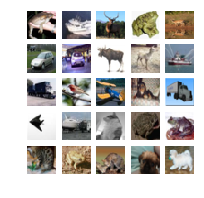

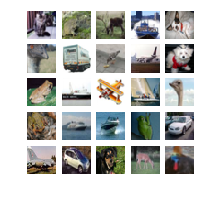

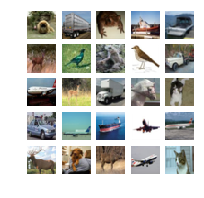

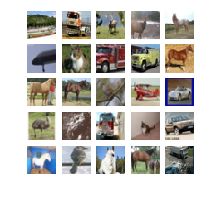

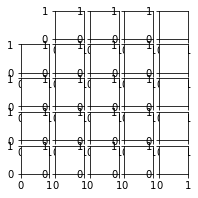

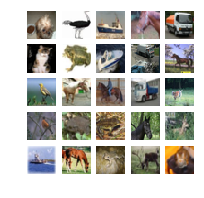

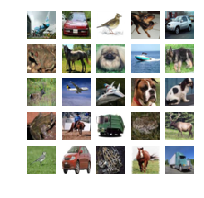

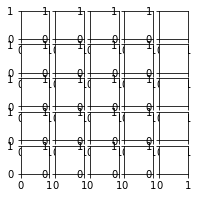

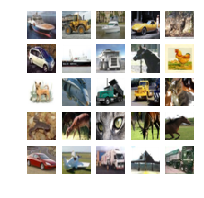

In [30]:
X = data_1[b'data'] 
Y = data_1[b'labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Randomly pick 25 images from data_batch_1 to visualize
#Visualizing CIFAR 10
plt.show()
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

In [2]:
ctx = mx.gpu

In [3]:
def transformer(data, label):
    data = mx.image.imresize(data, 224, 224)
    data = mx.nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)
    return data, label

In [4]:
batch_size = 64
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10('./data', train=True, transform=transformer),
    batch_size=batch_size, shuffle=True, last_batch='discard')

test_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10('./data', train=False, transform=transformer),
    batch_size=64, shuffle=False, last_batch='discard')

In [5]:
for d, l in train_data:
    break

In [6]:
print(d.shape, l.shape)
d.dtype

(64, 3, 224, 224) (64,)


numpy.float32

In [7]:
x_net = gluon.nn.Sequential()
with x_net.name_scope():
    #  First convolutional layer
    x_net.add(gluon.nn.Conv2D(channels=96, kernel_size=11, strides=(4,4), activation='relu'))
    x_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    #  Second convolutional layer
    x_net.add(gluon.nn.Conv2D(channels=192, kernel_size=5, activation='relu'))
    x_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=(2,2)))
    # Third convolutional layer
    x_net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu'))
    # Fourth convolutional layer
    x_net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu'))
    # Fifth convolutional layer
    x_net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, activation='relu'))
    x_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    # Flatten and apply fullly connected layers
    x_net.add(gluon.nn.Flatten())
    x_net.add(gluon.nn.Dense(4096, activation="relu"))
    x_net.add(gluon.nn.Dense(4096, activation="relu"))
    x_net.add(gluon.nn.Dense(10))


In [8]:
#initialize parameters
x_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

TypeError: 'function' object is not iterable

In [89]:
#optimizer
trainer = gluon.Trainer(x_net.collect_params(), 'sgd', {'learning_rate': .001})

RuntimeError: Parameter sequential4_conv0_bias has not been initialized

In [ ]:
#Softmax cross-entropy loss
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
#Evaluation loop
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for d, l in data_iterator:
        data = d.as_in_context(ctx)
        label = l.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [ ]:
epochs = 1
smoothing_constant = .01


for e in range(epochs):
    for i, (d, l) in enumerate(train_data):
        data = d.as_in_context(ctx)
        label = l.as_in_context(ctx)
        with autograd.record():
            output = alex_net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

    test_accuracy = evaluate_accuracy(test_data, alex_net)
    train_accuracy = evaluate_accuracy(train_data, alex_net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

In [ ]:
class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.conv1 = nn.Conv2D(6, kernel_size=5)
            self.pool1 = nn.MaxPool2D(pool_size=(2,2))
            self.conv2 = nn.Conv2D(16, kernel_size=5)
            self.pool2 = nn.MaxPool2D(pool_size=(2,2))
            self.fc1 = nn.Dense(120)
            self.fc2 = nn.Dense(84)
            self.fc3 = nn.Dense(10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # 0 means copy over size from corresponding dimension.
        # -1 means infer size from the rest of dimensions.
        x = x.reshape((0, -1))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Preparing data for deep learning algorithm (currently working on this part)

In [268]:
#function works so doing so for all data

#TODO: want to create a dictionary that directly maps the labels to the corresponding array of uint8s 

all_array_list_data = []
all_array_list_label = []

for k in range(1,6):
    filepath = 'C:\\Users\\594084\\Desktop\\Deep Learning\\cifar-10-batches-py\\data_batch_'
    dictionary = unpickle(filepath + str(k))
    for i in range(10000):
        all_array_list_data.append(dictionary[b'data'][i])
        all_array_list_label.append(dictionary[b'labels'][i])

In [2]:
# data = mx.symbol.Variable('data')
# fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
# act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
# fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
# act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
# fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=num_classes)
# mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

NameError: name 'num_classes' is not defined

In [284]:
# for i in range(50000):
#     dictionary[str(all_array_list_label[i])] = all_array_list_data[i]
# len(dictionary)



156

In [274]:
# for i in all_array_list_data:
#     for j in all_array_list_label:
#         dictionary = dict(zip(all_array_list_label[j], all_array_list_data[i]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [252]:
# for k in range(1,6):
#     filepath = 'C:\\Users\\594084\\Desktop\\Deep Learning\\cifar-10-batches-py\\data_batch_'
#     dictionary = unpickle(filepath + str(k))
#     all_array_list_data.append(dictionary[b'data'])
#     all_array_list_label.append(dictionary[b'labels'])
    
#     x = x.reshape(1000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
#     y = np.array(y)
#     fig, axes1 = plt.subplots(5,5,figsize=(3,3))
#     for j in range(5):
#         for j in range(5):
#             i = np.random.choice(range(len(x)))
#             axes1[j][k].set_axis_off()
#             axes1[j][k].imshow(x[i:i+1][0])

NameError: name 'numpy' is not defined

In [230]:
# X = ["data"] 
# Y = datadict['labels']
# X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
# Y = np.array(Y)

[{b'batch_label': b'training batch 1 of 5',
  b'data': array([[ 59,  43,  50, ..., 140,  84,  72],
         [154, 126, 105, ..., 139, 142, 144],
         [255, 253, 253, ...,  83,  83,  84],
         ..., 
         [ 71,  60,  74, ...,  68,  69,  68],
         [250, 254, 211, ..., 215, 255, 254],
         [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8),
  b'filenames': [b'leptodactylus_pentadactylus_s_000004.png',
   b'camion_s_000148.png',
   b'tipper_truck_s_001250.png',
   b'american_elk_s_001521.png',
   b'station_wagon_s_000293.png',
   b'coupe_s_001735.png',
   b'cassowary_s_001300.png',
   b'cow_pony_s_001168.png',
   b'sea_boat_s_001584.png',
   b'tabby_s_001355.png',
   b'muntjac_s_001000.png',
   b'arabian_s_001354.png',
   b'quarter_horse_s_000672.png',
   b'passerine_s_000343.png',
   b'camion_s_001895.png',
   b'trailer_truck_s_000335.png',
   b'dumper_s_000821.png',
   b'alley_cat_s_000200.png',
   b'accentor_s_000677.png',
   b'frog_s_001671.png',
   b'capreolus_capre

In [233]:
# %matplotlib inline 
# images = []
# for i in range(5):
#     img = tupled_data[i][b'data']
#     single_img = np.array(img[i])
#     single_img_reshaped = np.transpose(np.reshape(single_img,(1000,3, 32,32)), (1,2,0))
#     images.append(single_img_reshaped)



ValueError: cannot reshape array of size 3072 into shape (1000,3,32,32)